<center>
<H2>Dual Contouring</H2>
</center>

A Presentation of: 

<TABLE style="border: 0px;">
<TR style="border: 0px;">
<TD width=50 style="border: 0px;"></TD>
<TD style="border: 0px;">
Tao Ju, Frank Losasso, Scott Schaefer and Joe Warren. *Dual Contouring of Hermite Data.* Proceedings of SIGGRAPH. 1995 
</TD>
<TD width=50 style="border: 0px;"></TD>
</TR>
</TABLE>

Presented by Rupert Brooks at [Montreal Papers We Love Meetup 29-Nov-2017](https://www.meetup.com/Papers-We-Love-Montreal/events/244906577)

#### Notebook preliminaries

In [ ]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;   }

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [4]:
import vtk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import mha

%matplotlib inline
fig_size_inline = (13, 9)
plt.rcParams["figure.figsize"] = fig_size_inline
#%matplotlib notebook
#fig_size_notebook = (9, 7)
#plt.rcParams["figure.figsize"] = fig_size_notebook

# a lot of this code is extremely verbose.  To keep it concise, 
# details have been put in a separate file
from detail import *

### Outline
0. Problem statement and definitions
0. Marching Cubes
0. The dual graph
0. Quadratic error functions
0. Polygonizing octrees
0. Further development



### Problem statement and definitions

This algorithm is one of a family of approaches that generate a surface mesh from an implicitly defined function on a grid.

The surface is generated on a isolevel set of a function.  In 2D this is a contour.  In 3D, it is an isosurface.

In [ ]:
fig=plt.figure()
x,y=np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
z=np.sinc(np.sqrt(x**2+y**2)*0.5)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(x,y,z,rstride=2, cstride=2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax=plt.subplot(1,2,2)
plt.contour(z,[0])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
dataset=mha.new("data/brainweb1e1a10f20.mha")
outline,data=MarchingCubes(dataset.data,128)
SetColor(outline,Black)
SetColor(data,Purple)
renderer=RenderActors([outline,data])
vtk_show(renderer,800,600)

#### Why would you do this?

+ Some data just naturally is this way (CT,MRI)
+ representation of an object as a distance field
+ certain types of editing are easy


### Marching cubes

So how do we build the surface?  A classic method is *Marching cubes*.

<TABLE style="border: 0px;">
<TR style="border: 0px;">
<TD width=50 style="border: 0px;"></TD>
<TD style="border: 0px;">
Bill Lorenson and Harvey Cline. *Marching Cubes: A high-resolution 3D surface reconstruction algorithm.* Bill Lorenson and Harvey Cline, 1987.
</TD>
<TD width=50 style="border: 0px;"></TD>
</TR>
</TABLE>

1. Given - values of a function at points (voxels) in a grid
2. Consider the *cells* of this grid.  That is the cubes formed by the lines connecting neighbors.


In [ ]:
img_data=np.zeros((4,3,5),dtype=np.uint8,order='C')
primal,primalPoints=MakePrimalGrid(img_data)
SetColor(primal,Magenta)
SetColor(primalPoints,Red)
renderer=RenderActors([primal,primalPoints],False)
vtk_show(renderer,800,600)

0. Now imagine there is actually some data in this instead of zeros. The surface we want will have to pass in between the value higher than the level we have selected, and the value lower.  It will have to cut that edge.



In [ ]:
img_data[1,1,1]=255
img_data[2,1,1]=200
img_data[2,1,2]=180
img_data[2,1,3]=150
primal,primalPoints=MakePrimalGrid(img_data)
SetColor(primal,Magenta)
SetColor(primalPoints,Red)
renderer=RenderActors([primal,primalPoints],False,(.1,0,.1))
vtk_show(renderer,800,600)

So in every cube we can determine what is happening by looking at the corners.  If all the corners are in, or all the corners are out, there is no surface.  But if some are in and some are out, then there is a surface inside.  There are $2^8$ possible combinations, so to determine the triangles inside, we can use a lookup table.

<CENTER>
![marching cubes lookup](images/MarchingCubes.png)
[(c) Wikipedia](https://en.wikipedia.org/wiki/File:MarchingCubes.svg)
</CENTER>


The table is simple in principle, if a bit tedious to create, but Paul Bourke provided an excellent implementation [here](http://paulbourke.net/geometry/polygonise/).  A rumor has it that this might be the most copy pasted code of all time!  See [0fps's blog post](https://0fps.net/2012/07/12/smooth-voxel-terrain-part-2/)  for discussion.

Anyway, lets take a look.

In [ ]:

outline,data=MarchingCubes(img_data,100)
SetColor(outline,Black)
SetLineWidth(outline,2)
SetColor(data,Magenta)

xa,ya,za=MakeAxes((-1.3,-1.3,-1.3),0.5)

renderer=RenderActors([data,primal,primalPoints,xa,ya,za],False)
vtk_show(renderer,800,600)

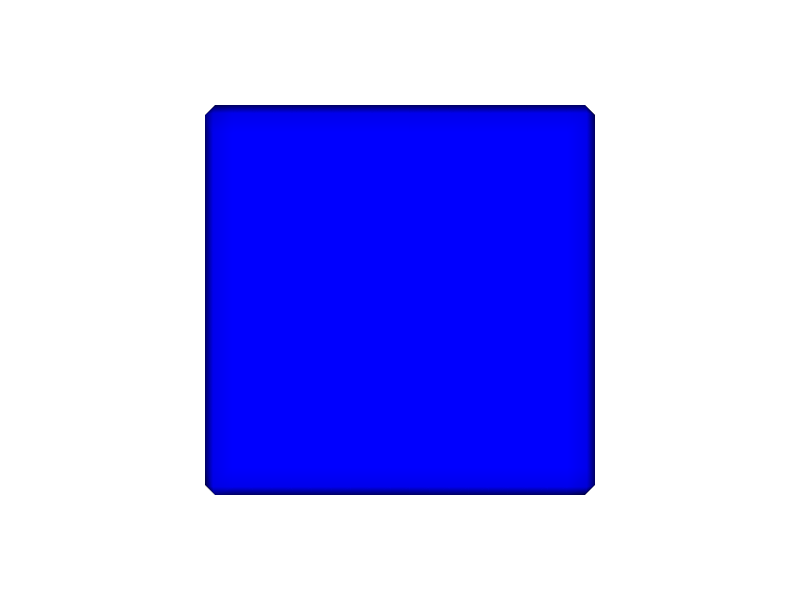

In [20]:
cube_data=np.zeros((24,24,24),dtype=np.uint8,order='C')
cube_data[2:-2,2:-2,2:-2]=255

_,cubemesh=MarchingCubes(cube_data,128)
SetColor(cubemesh,Magenta)

renderer=RenderActors([cubemesh],False)
vtk_show(renderer,800,600)


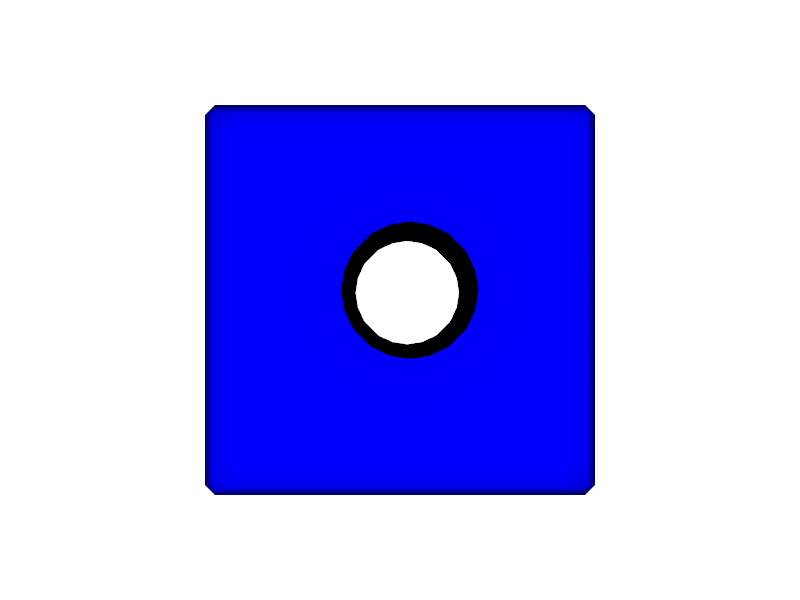

In [31]:
cube_data_with_hole=cube_data*np.uint8(1)
middle=np.array(cube_data_with_hole.shape)*0.5
for i in range(cube_data_with_hole.shape[0]):
    for j in range(cube_data_with_hole.shape[1]):
        for k in range(cube_data_with_hole.shape[2]):
            dx=i-middle[0]
            dy=j-middle[1]
            r=np.sqrt(dx*dx+dy*dy)
            r=r*255.0/7.0
            if r>255:
                r=255
            cube_data_with_hole[i,j,k]=min(r,cube_data_with_hole[i,j,k])

_,cubemesh_with_hole=MarchingCubes(cube_data_with_hole,128)
SetColor(cubemesh_with_hole,Magenta)

renderer=RenderActors([cubemesh_with_hole],False)
vtk_show(renderer,800,600)

#### Limitations of Marching Cubes
* Smooths the data where you don't want it to
* Sometimes makes more jaggies than you want.
* Makes many more triangles than are really necessary



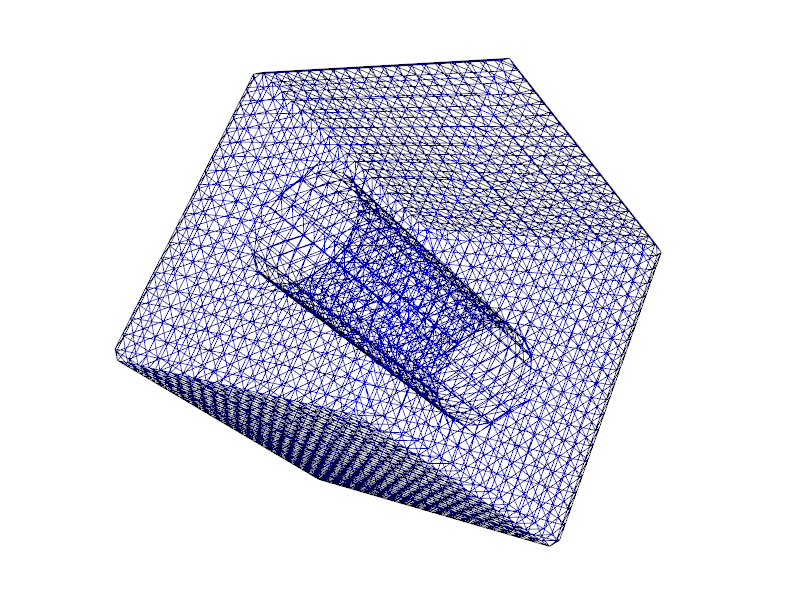

In [28]:
renderer=RenderActors([cubemesh_with_hole])
vtk_show(renderer,800,600)


### The Dual Graph

So to address these issues, these folks propose
* To address the shape issues by
   * adding more data to our data structure 
   * using that data to position new points of the *dual grid*
* To address the number of triangles by working on an octree.

Ok first, what is the dual grid.  It is the grid "in-between" the voxels, connecting the cubes from the previous step across their faces.


In [30]:
dual,dualPoints=MakeDualGrid(img_data)
SetColor(dual,Brown)
SetColor(dualPoints,Blue)
renderer=RenderActors([primal,primalPoints,dual,dualPoints],False)
vtk_show(renderer,800,600)

NameError: name 'img_data' is not defined

For the extra data, they propose to have intersection points of their contour on each edge (of the primal) along with normals to the isosurface at that point.

This is where the "Hermite data" comes from in the title.  Hermite interpolation is interpolation which takes as input both the values and derivatives of a function at a set of points.  Invented by this guy:

<CENTER>
![charles hermite frowning](images/Charles_Hermite.jpg)
Charles Hermite [Wikipedia](https://en.wikipedia.org/wiki/Charles_Hermite#/media/File:Charles_Hermite_circa_1901_edit.jpg)
</CENTER>

How did they get it?  In the examples given they probably obtained it from the original surface which they used to create their signed distance field.

### Quadratic error function

Given that data, they position the dual point in each cube that has an edge that changes sign.  And they position it at the minimizer of this function.

<center>
$E[x]=\sum\left( n_i\cdot(x-p_i)\right)^2$
</center>

Ok, so how does this thing behave?

i: 0.0
i: 1
i: nan
i: nan
i: 0.0
i: 1
i: nan
i: nan


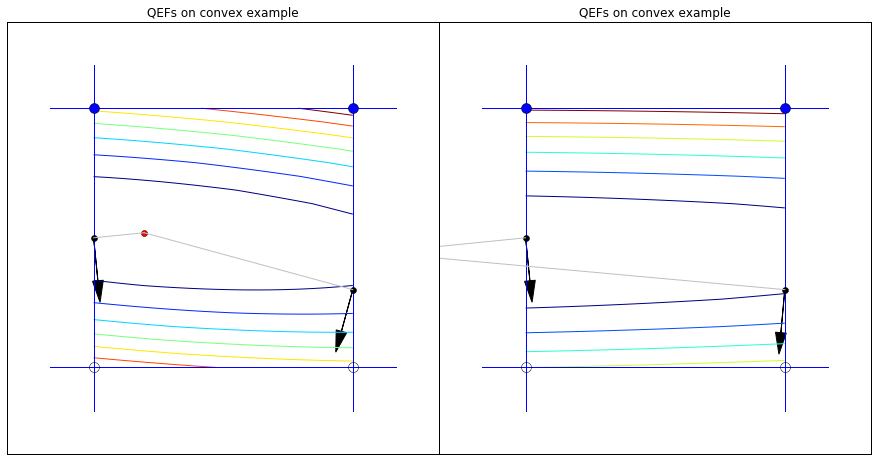

i: 0.0
i: 1
i: nan
i: nan
i: 0.0
i: 1
i: nan
i: nan


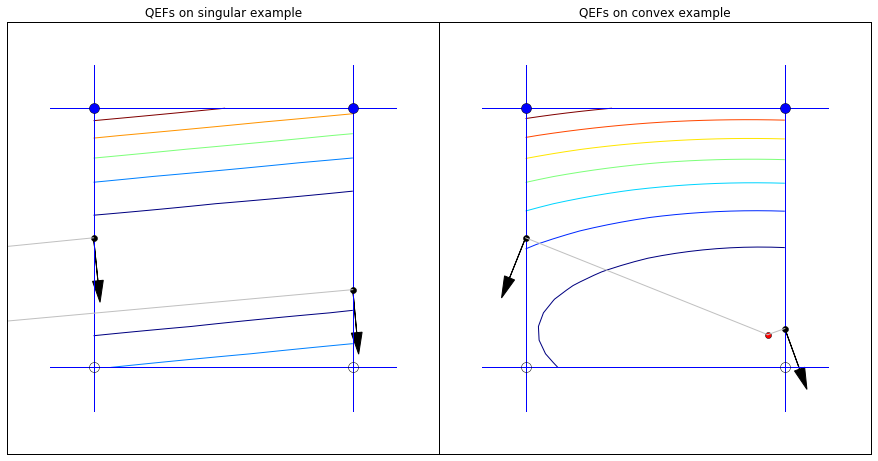

In [19]:
axprops = dict(xticks=[], yticks=[])
#cs=[0,1,0,0]
#ps=[(0.,0.5),(0.5,1.),(np.nan,np.nan),(np.nan,np.nan)]
#ns=[np.array(n)/np.sqrt(np.sum(np.array(n)**2)) for n in [(1.1,-1),(1.,-1.1),(np.nan,np.nan),(np.nan,np.nan)]]
fig = plt.figure(figsize=(12,6))

ax = fig.add_axes([0.0, 0.0, 0.5, 1.0], **axprops)
cs=[0,1,0,1]
ps=[(0.,0.5),(1,0.3),(np.nan,np.nan),(np.nan,np.nan)]
ns=[np.array(n)/np.sqrt(np.sum(np.array(n)**2)) 
    for n in [(0.1,-1),(-0.3,-1.1),(np.nan,np.nan),(np.nan,np.nan)]]
DrawQEFProblem(ax,cs,ps,ns)
ax.set_title("QEFs on convex example")

ax = fig.add_axes([0.5, 0.0, 0.5, 1.0], **axprops)
cs=[0,1,0,1]
ps=[(0.,0.5),(1,0.3),(np.nan,np.nan),(np.nan,np.nan)]
ns=[np.array(n)/np.sqrt(np.sum(np.array(n)**2)) 
    for n in [(0.1,-1),(-0.1,-1.1),(np.nan,np.nan),(np.nan,np.nan)]]
DrawQEFProblem(ax,cs,ps,ns)
ax.set_title("QEFs on convex example")
plt.show()

fig = plt.figure(figsize=(12,6))

ax = fig.add_axes([0.0, 0.0, 0.5, 1.0], **axprops)
cs=[0,1,0,1]
ps=[(0.,0.5),(1,0.3),(np.nan,np.nan),(np.nan,np.nan)]
ns=[np.array(n)/np.sqrt(np.sum(np.array(n)**2)) 
    for n in [(0.1,-1),(0.1,-1.1),(np.nan,np.nan),(np.nan,np.nan)]]
DrawQEFProblem(ax,cs,ps,ns)
ax.set_title("QEFs on singular example")

ax = fig.add_axes([0.5, 0.0, 0.5, 1.0], **axprops)
cs=[0,1,0,1]
ps=[(0.,0.5),(1,0.15),(np.nan,np.nan),(np.nan,np.nan)]
ns=[np.array(n)/np.sqrt(np.sum(np.array(n)**2)) 
    for n in [(-0.4,-1),(0.4,-1.1),(np.nan,np.nan),(np.nan,np.nan)]]
DrawQEFProblem(ax,cs,ps,ns)
ax.set_title("QEFs on convex example")
plt.show()



### Polygonizing Octrees

This approach so far helps with the resolution of the features in the resulting mesh.  But it doesn't help with the number of triangles.  They propose to polygonize an octree representation of the data.  They provide quadtree examples, but they are tiny, and I found them hard to follow.  Here is a larger sketch

<CENTER>
![Quadtree sketch](images/quadtree.jpg)
Quadtree
</CENTER>

The key, i think, is to realize that the quadtree is inherently a dual structure.  They recursively identify each *minimal* edge, and insert a point using the combined QEFs.  In the drawing, i just stuck the point in the middle of the edge.

<CENTER>
![Quadtree sketch with dual contour](images/quadtreedual.jpg)
Quadtree with dual contour
</CENTER>





### Further development
The authors took it further in a subsequent paper.

Schaefer and Warren. *Dual Marching Cubes: Primal contouring of dual grids.*  2004. https://www.cs.rice.edu/~jwarren/papers/dmc.pdf

If you really want to get to the state of the art, it can probably be found in [OpenVDB](http://www.openvdb.org/)
A software package by DreamWorks primarily developed by Ken Museth, Peter Cucka, Mihai Alden and David Hill.

### Acknowledgements
* head dataset from Brainweb http://brainweb.bic.mni.mcgill.ca/brainweb/
* Fonts from http://cm-unicode.sourceforge.net/
* Styling based on https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers